In [152]:
!pip install catboost

# SETUP

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import AdamW
import random
TRAIN_PATH = "/kaggle/input/axion-competition-2025/train.csv"
TEST_PATH = "/kaggle/input/axion-competition-2025/test.csv"
SUBMISSION_PATH = "/kaggle/input/axion-competition-2025/sample_submission.csv"
RANDOM_STATE = 42
import warnings
warnings.filterwarnings("ignore")

<h1>📋Load Dataframe Yang Dibutuhkan</h1>
<ul>
  <li>
    <strong>train</strong>
    <ul>
      <li>Dibaca dari file <code>train.csv</code>.</li>
      <li>Berisi data latih (training data) yang digunakan untuk melatih model machine learning.</li>
      <li>Kolom <code>'Record number'</code> dihapus karena kemungkinan tidak relevan untuk prediksi.</li>
      <li>Ganti kolom <code>'Timestamp'</code> menjadi tipe data <code>datetime</code> agar bisa digunakan untuk analisis berbasis waktu.</li>
    </ul>
  </li>
  
  <li>
    <strong>test</strong>
    <ul>
      <li>Dibaca dari file <code>test.csv</code>.</li>
      <li>Berisi data uji (testing data) tanpa label target.</li>
      <li>Kolom <code>'Record number'</code> dihapus karena kemungkinan tidak relevan untuk prediksi.</li>
      <li>Ganti kolom <code>'Timestamp'</code> menjadi tipe data <code>datetime</code> agar format waktu konsisten dengan data latih.</li>
    </ul>
  </li>

  <li>
    <strong>submission_sample</strong>
    <ul>
      <li>Dibaca dari file <code>sample_submission.csv</code>.</li>
      <li>Format yang digunakan untuk mengatur output prediksi sebelum disubmit ke Kaggle.</li>
    </ul>
  </li>
</ul>


In [154]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
train.drop("Record number", axis=1, inplace=True)
test.drop("Record number", axis=1, inplace=True)
train["Timestamp"] = pd.to_datetime(train["Timestamp"])
test["Timestamp"] = pd.to_datetime(test["Timestamp"])
train = train.sort_values('Timestamp')

In [155]:
numerical_cols = [col for col in train.columns if col not in ["Turbidity", "Timestamp"]]

In [156]:
train.head()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
0,2023-08-04 23:00:00,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068
2,2023-08-04 23:00:00,1.260,156.755,1.620,20.001,7.430,100.571,8.171,35.207,53.252,2.030
4,2023-08-04 23:00:00,3.397,244.637,1.635,19.986,7.429,100.538,8.171,35.208,53.253,1.944
5,2023-08-04 23:00:00,1.596,100.271,1.935,19.834,7.430,100.293,8.158,35.255,53.315,2.124
1,2023-08-04 23:30:00,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994


In [157]:
test.head()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance
0,2024-12-01 00:00:00,84.585,80.849,1.172,25.513,5.407,73.216,7.901,18.230,29.510
1,2024-12-01 00:10:00,NaN,81.950,1.203,25.529,5.497,74.441,7.908,18.141,29.379
2,2024-12-01 00:20:00,NaN,84.333,1.184,25.494,5.505,74.177,7.873,17.384,28.260
3,2024-12-01 00:30:00,NaN,83.426,1.172,25.537,5.473,74.321,7.902,18.660,30.142
4,2024-12-01 00:40:00,NaN,81.562,1.240,25.536,5.432,73.530,7.881,18.077,29.284


In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53448 entries, 0 to 53447
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Timestamp                       53448 non-null  datetime64[ns]
 1   Average Water Speed             53229 non-null  float64       
 2   Average Water Direction         53447 non-null  float64       
 3   Chlorophyll                     51744 non-null  float64       
 4   Temperature                     44234 non-null  float64       
 5   Dissolved Oxygen                49139 non-null  float64       
 6   Dissolved Oxygen (%Saturation)  47690 non-null  float64       
 7   pH                              52355 non-null  float64       
 8   Salinity                        49481 non-null  float64       
 9   Specific Conductance            52072 non-null  float64       
 10  Turbidity                       47382 non-null  float64       
dtypes: date






<h1>🔎EDA(Explaratory Data Analysis)</h1>
<ul> <li> <strong>1. Melihat struktur data</strong> <ul> <li>Cek bentuk data: <code>df.shape</code></li> <li>Lihat beberapa baris pertama: <code>df.head()</code></li> <li>Periksa tipe data: <code>df.dtypes</code></li> </ul> </li> <li> <strong>2. Memeriksa missing values</strong> <ul> <li>Cari jumlah nilai hilang: <code>df.isnull().sum()</code></li> <li>Visualisasi missing values (misalnya pakai <code>sns.heatmap()</code>)</li> </ul> </li> <li> <strong>3. Statistik deskriptif</strong> <ul> <li>Gunakan <code>df.describe()</code> untuk melihat mean, std, min, max, dll.</li> <li><code>value_counts()</code> untuk data kategorikal.</li> </ul> </li> <li> <strong>4. Visualisasi distribusi fitur</strong> <ul> <li>Histogram atau KDE plot: <code>sns.histplot()</code>, <code>sns.kdeplot()</code></li> <li>Barplot untuk fitur kategorikal: <code>sns.countplot()</code></li> </ul> </li> <li> <strong>5. Analisis hubungan antar fitur</strong> <ul> <li>Hitung korelasi antar fitur numerik: <code>df.corr()</code></li> <li>Visualisasi dengan heatmap: <code>sns.heatmap()</code></li> </ul> </li> <li> <strong>6. Analisis hubungan fitur dengan target</strong> <ul> <li>Boxplot: <code>sns.boxplot(x=target, y=feature)</code></li> <li><code>groupby()</code> + <code>mean()</code> untuk analisis ringkasan</li> </ul> </li> <li> <strong>7. Outlier detection</strong> <ul> <li>Gunakan boxplot untuk mendeteksi outlier</li> <li>Pakai IQR (Interquartile Range) untuk deteksi manual</li> </ul> </li> </ul>


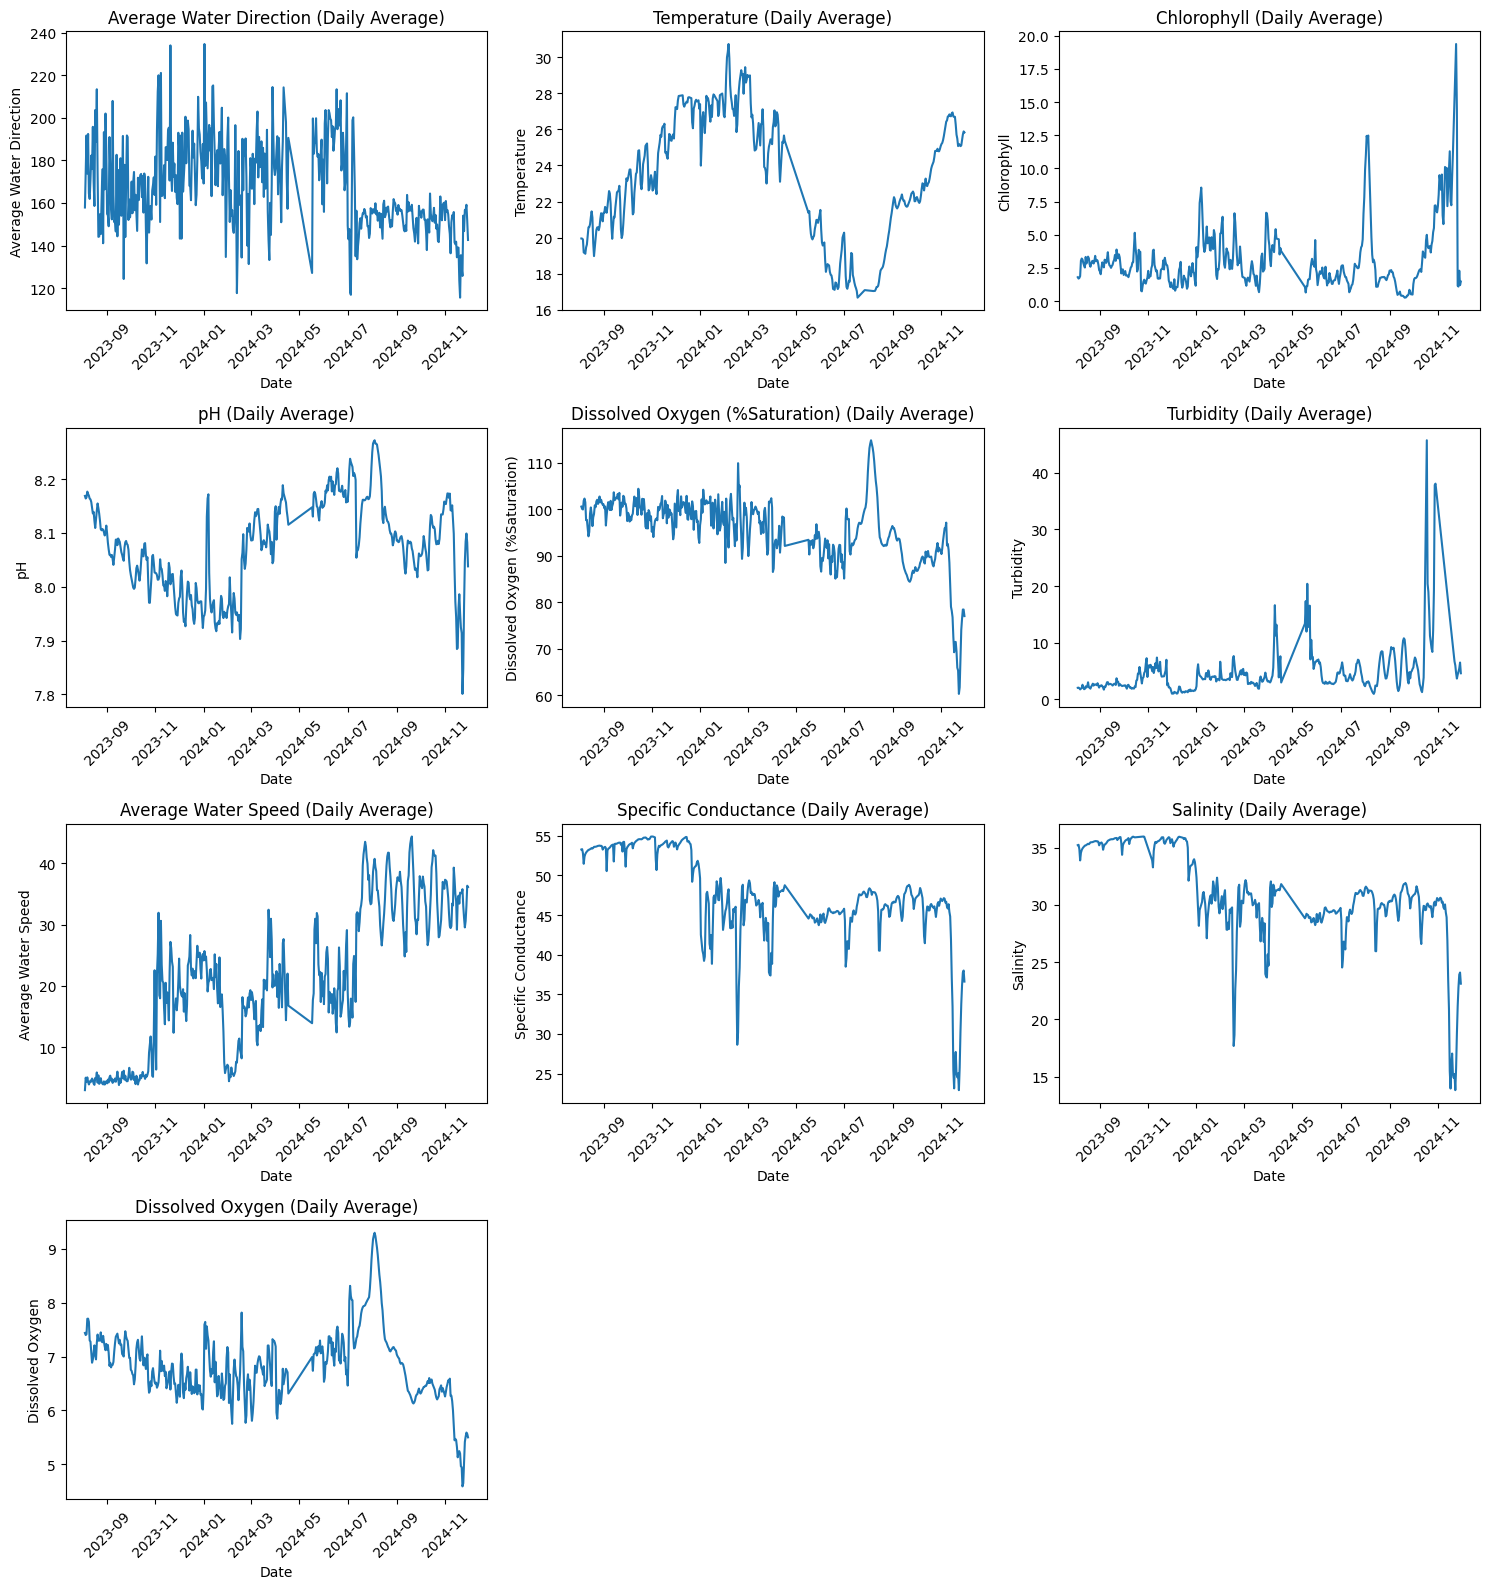

In [159]:
data_resampled = (train.set_index('Timestamp').resample('D').mean().reset_index())

cols_to_plot = list(set(numerical_cols + ["Turbidity"]))
n_cols = 3
n_rows = math.ceil(len(cols_to_plot) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.lineplot(x='Timestamp', y=col, data=data_resampled, ax=axes[i])
    axes[i].set_title(f"{col} (Daily Average)", fontsize=12)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [160]:
#Hanya Kolom Numerical
train.describe()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
count,53448,53229.000000,53447.000000,51744.000000,44234.000000,49139.000000,47690.000000,52355.000000,49481.000000,52072.000000,47382.000000
mean,2024-05-09 16:57:38.398069248,23.816720,166.995659,3.354631,23.574391,6.838319,94.034472,8.082660,29.970945,46.393371,4.637636
min,2023-08-04 23:00:00,0.000000,0.000000,0.100000,16.249000,3.030000,51.836000,7.309000,0.014000,0.021000,0.075000
25%,2024-01-24 13:07:30,8.665000,83.769500,1.437000,21.120000,6.312000,88.783000,8.015000,28.984000,44.797000,2.537000
50%,2024-05-29 14:35:00,18.316000,146.878000,2.408000,23.731000,6.778000,94.172500,8.091000,30.182000,46.599500,3.439000
75%,2024-08-30 20:02:30,32.880000,257.125000,3.959000,26.399000,7.328000,99.533000,8.151000,31.631000,48.819000,5.135000
max,2024-11-30 23:50:00,89.912000,359.994000,49.234000,32.063000,9.911000,134.082000,8.321000,36.000000,54.996000,49.984000
std,NaN,19.429327,97.985736,3.359453,3.377334,0.834126,9.630689,0.093691,3.940893,5.741360,4.486299


In [161]:
# Hanya Kolom Numerical
test.describe()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance
count,14610,13747.000000,14610.000000,14604.000000,14606.000000,14604.000000,14034.000000,14577.000000,14447.000000,14546.000000
mean,2025-01-20 17:25:00.041067776,33.893951,144.356581,1.390966,27.416403,5.445127,76.778949,7.907776,16.544267,26.496678
min,2024-12-01 00:00:00,0.000000,0.000000,0.105000,21.568000,3.002000,50.029000,7.002000,0.060000,0.000000
25%,2024-12-26 08:42:30,13.148000,83.195000,0.754000,27.009000,5.051750,70.687000,7.841000,11.692500,19.328500
50%,2025-01-20 17:25:00,26.100000,89.877500,1.093000,27.544000,5.494000,76.986000,7.945000,17.526000,28.449000
75%,2025-02-15 02:07:30,53.411500,245.481500,1.717000,28.127000,5.910000,84.394250,8.055000,22.062500,35.086750
max,2025-03-12 11:00:00,89.972000,359.945000,38.753000,30.318000,9.117000,132.328000,8.437000,32.324000,49.507000
std,NaN,24.677887,85.828475,1.079571,1.033310,0.836550,11.188724,0.207194,8.086016,12.466998


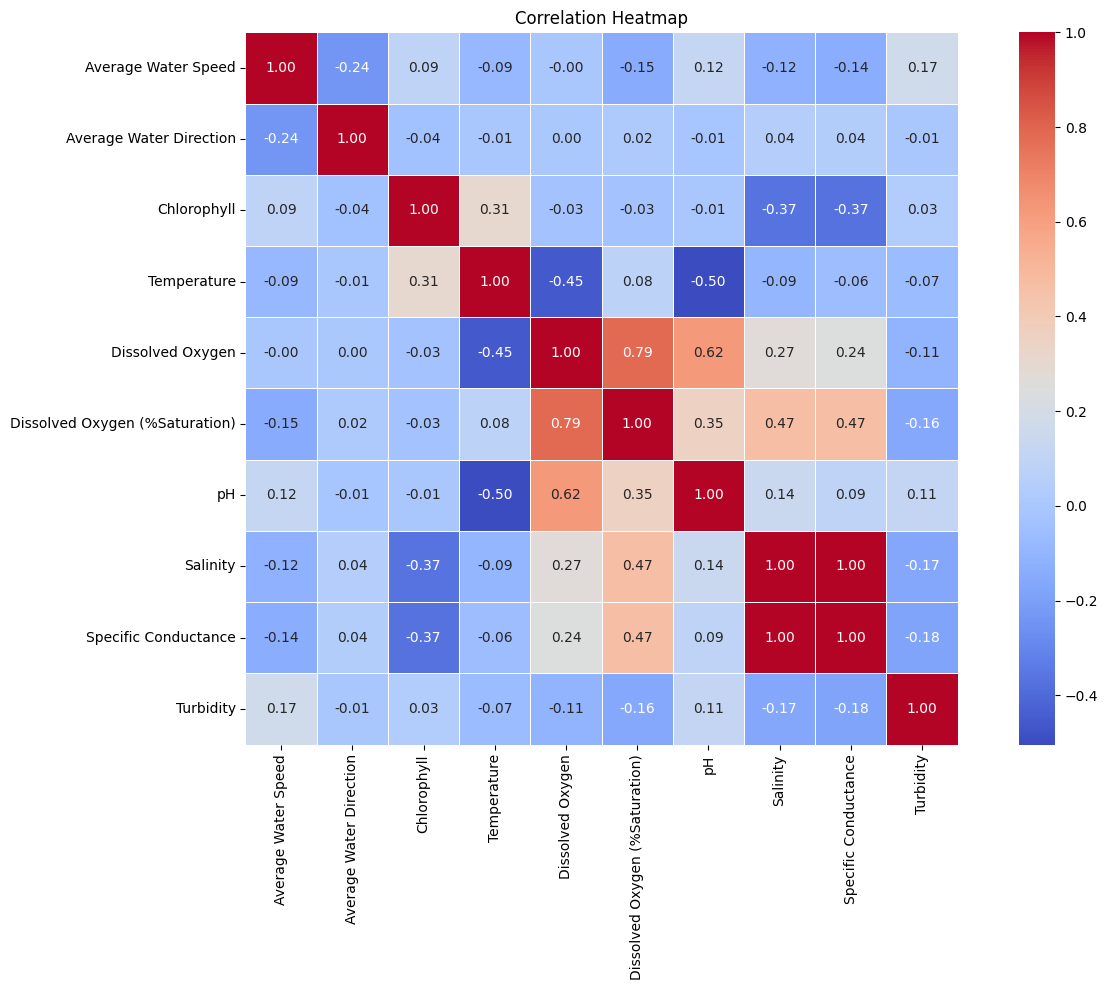

In [162]:
corr_matrix = train.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

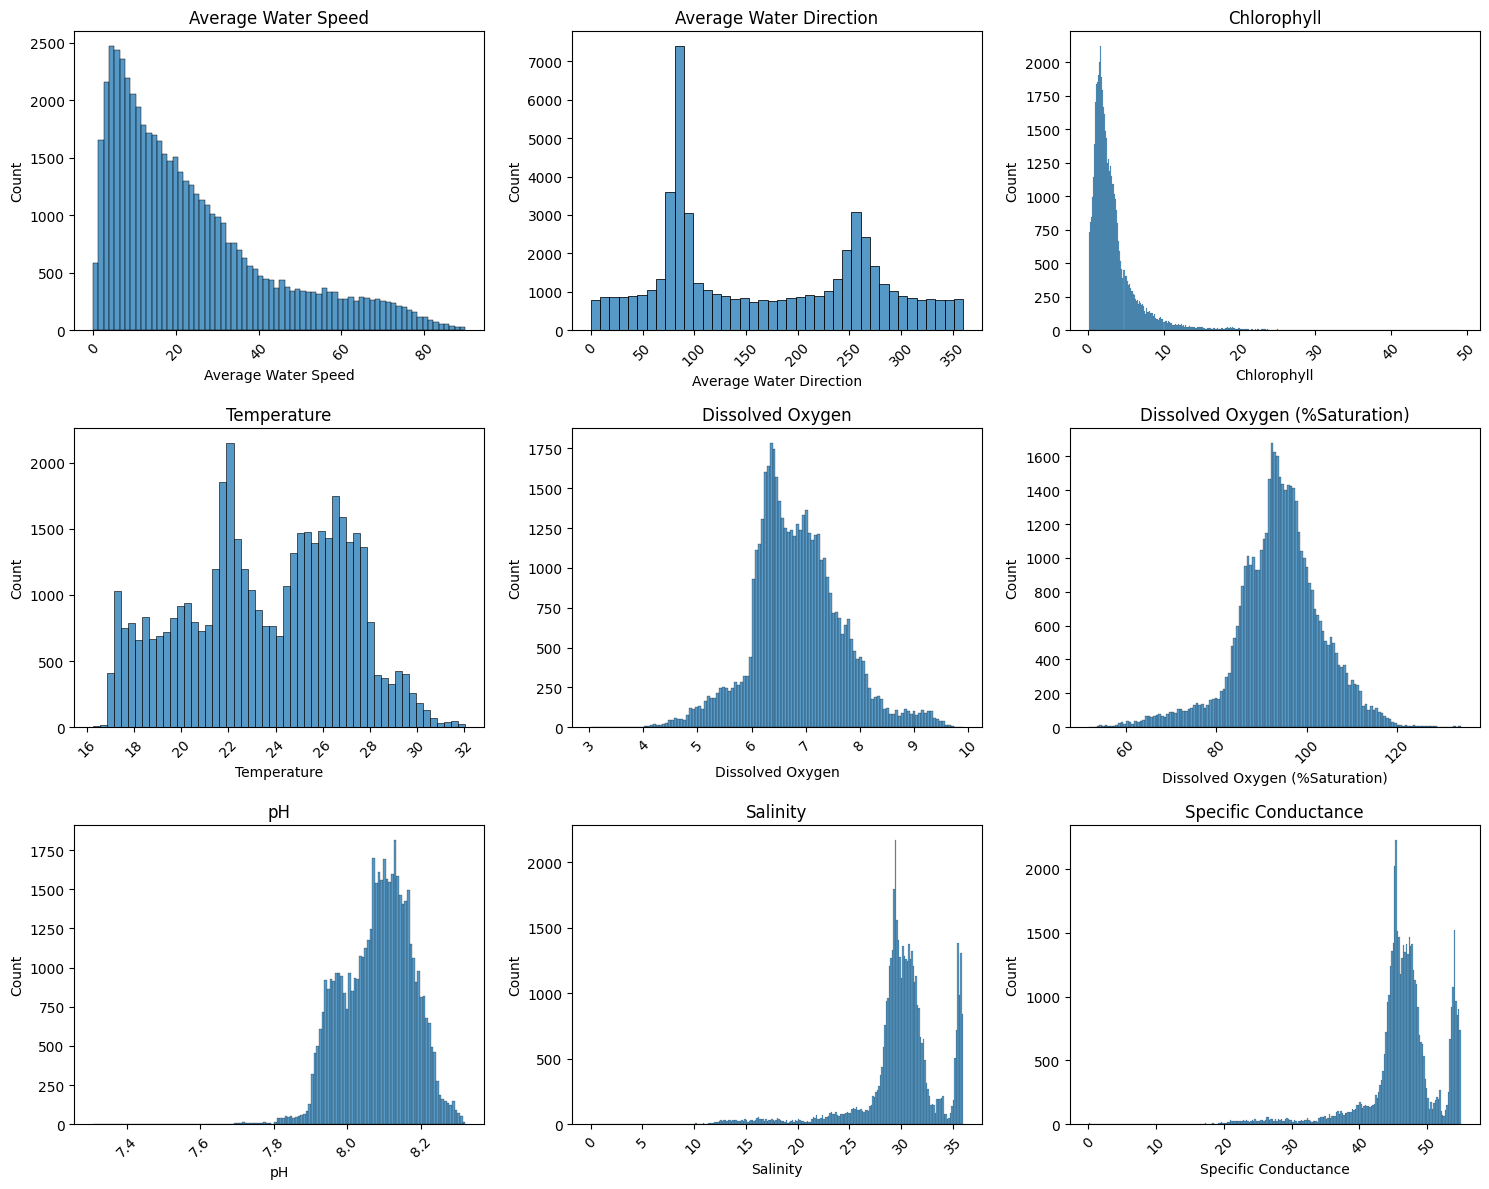

In [163]:
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

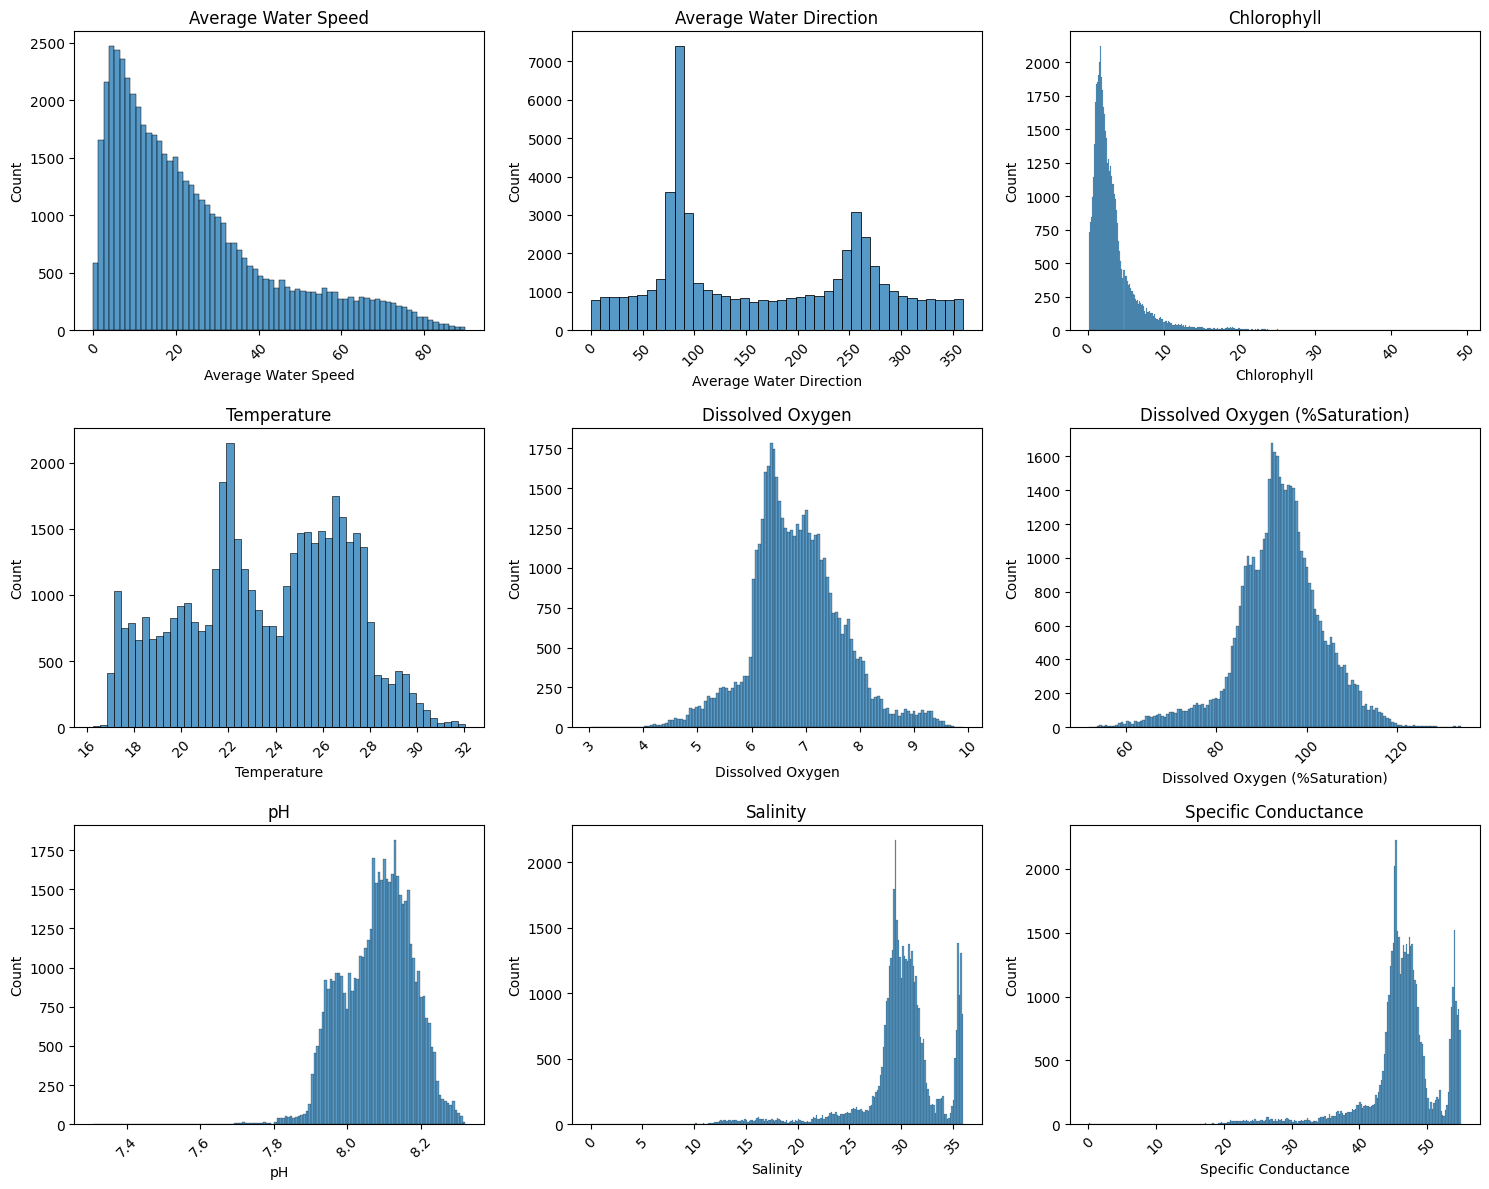

In [164]:
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=12)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

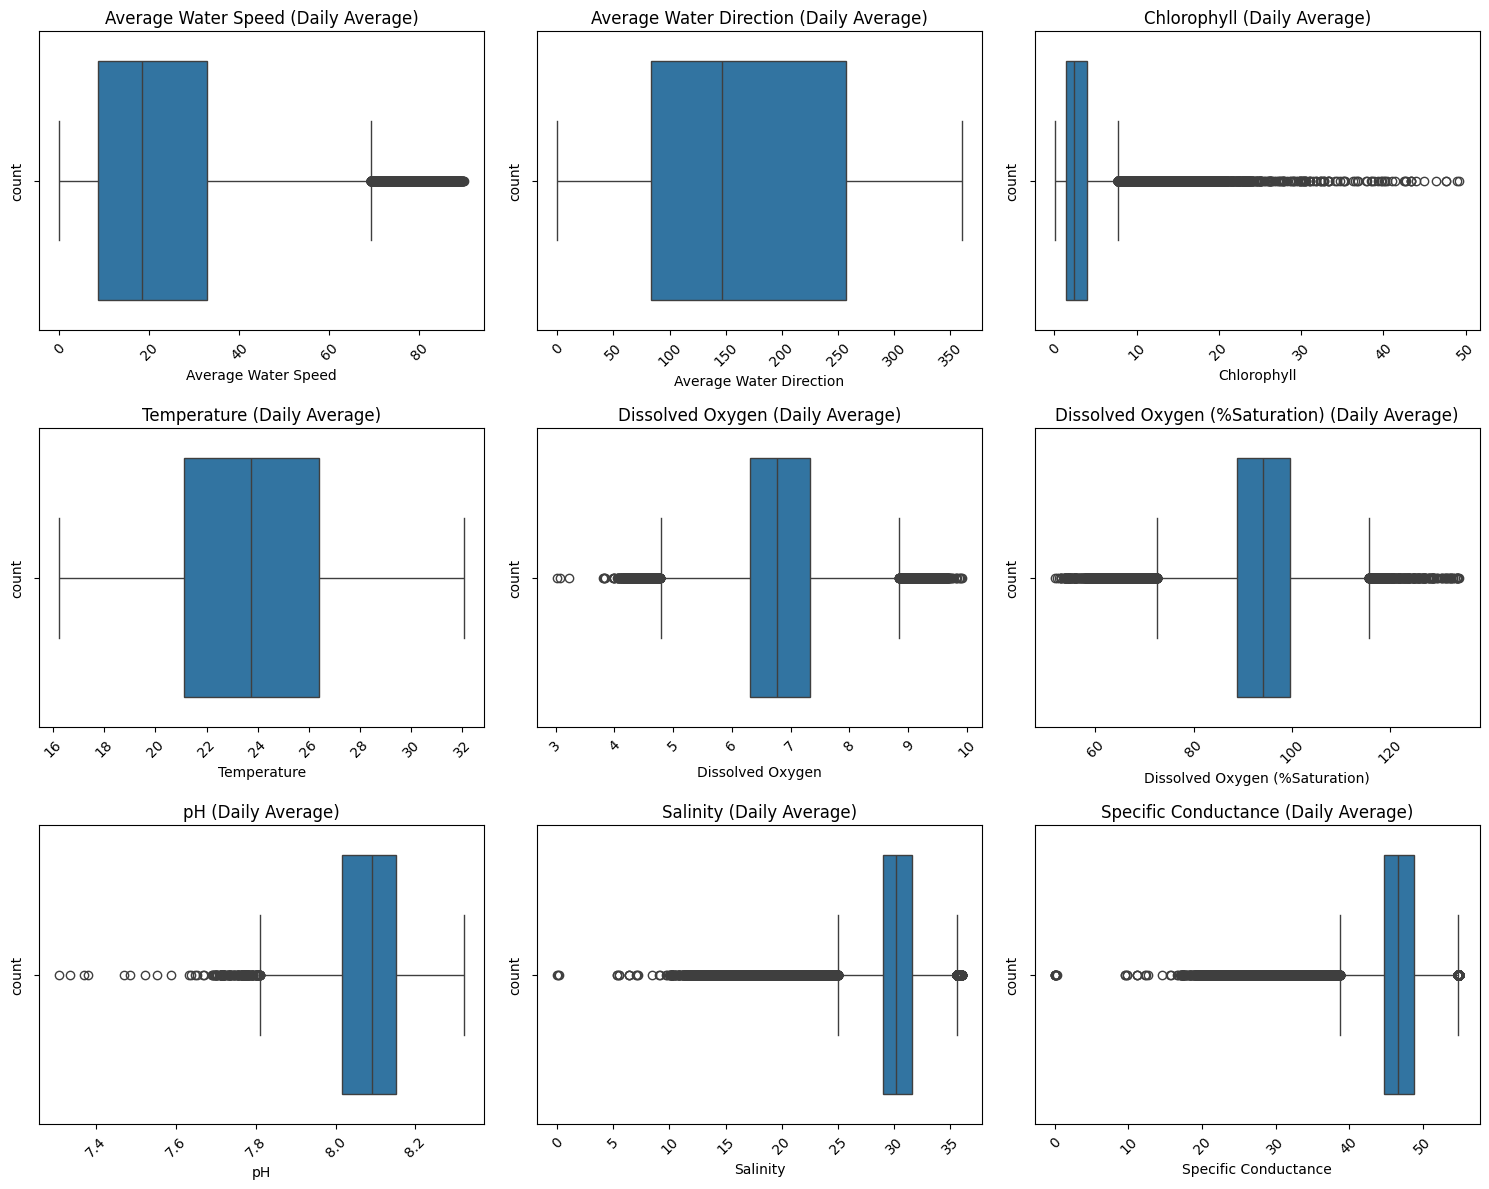

In [165]:
n_cols = 3
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f"{col} (Daily Average)", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [166]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[col].apply(lambda x: 'Outlier' if (x < lower_bound or x > upper_bound) else 'Normal')

def analyze_outlier_influence(df, target_col='Turbidity'):
    numerical_cols = [col for col in df.select_dtypes(include='number').columns if col != target_col]
    results = []

    for col in numerical_cols:
        df['Outlier'] = detect_outliers(df, col)
        mean_turbidity = df.groupby('Outlier')[target_col].mean()
        count = df['Outlier'].value_counts()
        results.append({
            'Feature': col,
            'Normal Count': count.get('Normal', 0),
            'Outlier Count': count.get('Outlier', 0),
            'Normal Mean Turbidity': mean_turbidity.get('Normal', float('nan')),
            'Outlier Mean Turbidity': mean_turbidity.get('Outlier', float('nan'))
        })

    return pd.DataFrame(results)
analyze_outlier_influence(train)
train.drop("Outlier", axis=1, inplace=True)


# Dara Preprocessing

In [167]:
train_length = int(len(train) * 0.8)
data_train = train.loc[:train_length]
data_valid = train.loc[train_length:]

## Missing Value

## Must drop missing target

In [168]:
data_train.isna().sum().to_frame("Missing Value Count")

,Missing Value Count
Timestamp,0
Average Water Speed,22
Average Water Direction,1
Chlorophyll,1066
Temperature,9205
Dissolved Oxygen,4300
Dissolved Oxygen (%Saturation),5749
pH,1084
Salinity,3958
Specific Conductance,1367


In [169]:
data_train.dropna(subset="Turbidity", inplace=True)
data_valid.dropna(subset="Turbidity", inplace=True)

In [170]:
median_train_info = {}
for col in numerical_cols:
    med = data_train[col].median()
    median_train_info[col] = med
    data_train[col] = data_train[col].fillna(med)

## Outlier

In [171]:
upper_value = {}
lower_value = {}

def cap_outliers(df, col, lower_q=0.10, upper_q=0.90, is_train=True):
    """Cap nilai di bawah quantile lower dan di atas quantile upper."""
    global lower_value, upper_value

    if is_train:
        lower_bound = df[col].quantile(lower_q)
        upper_bound = df[col].quantile(upper_q)
        lower_value[col] = lower_bound
        upper_value[col] = upper_bound
    else:
        lower_bound = lower_value[col]
        upper_bound = upper_value[col]

    df[col] = np.where(df[col] < lower_bound, lower_bound,
              np.where(df[col] > upper_bound, upper_bound, df[col]))

    return df[col]


for col in numerical_cols:
    data_train[col] = cap_outliers(data_train, col, is_train=True)

## Feature Engineering


In [172]:
data_train['year'] = data_train['Timestamp'].dt.year
data_train['month'] = data_train['Timestamp'].dt.month
data_train['day'] = data_train['Timestamp'].dt.day
data_train['hour'] = data_train['Timestamp'].dt.hour

In [173]:
data_train.drop("Timestamp", axis=1 ,inplace=True)

## Feature Scalling

In [174]:
X_train = data_train.drop(columns=['Turbidity'])
y_train = data_train['Turbidity']

In [175]:
numerical_cols = list(X_train.select_dtypes(include="number").columns)
numerical_cols

['Average Water Speed',
 'Average Water Direction',
 'Chlorophyll',
 'Temperature',
 'Dissolved Oxygen',
 'Dissolved Oxygen (%Saturation)',
 'pH',
 'Salinity',
 'Specific Conductance',
 'year',
 'month',
 'day',
 'hour']

In [176]:
sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])


# Transforming Validation

In [213]:
X_valid = data_valid.drop(columns=['Turbidity'])
y_valid = data_valid['Turbidity']

In [214]:
X_valid['year'] = X_valid['Timestamp'].dt.year
X_valid['month'] = X_valid['Timestamp'].dt.month
X_valid['day'] = X_valid['Timestamp'].dt.day
X_valid['hour'] = X_valid['Timestamp'].dt.hour

X_valid = X_valid.drop("Timestamp", axis=1)

In [215]:
for col in numerical_cols:
    X_valid[col] = cap_outliers(X_valid, col, is_train=True)

In [216]:
cols_to_fill = [col for col in numerical_cols if col not in ["year", "month", "day", "hour"]]
for col in cols_to_fill:
    X_valid[col] = X_valid[col].fillna(X_valid[col].median())

In [217]:
X_valid[numerical_cols] = sc.transform(X_valid[numerical_cols])

In [218]:
X_valid.isna().sum()

,0
Average Water Speed,0
Average Water Direction,0
Chlorophyll,0
Temperature,0
Dissolved Oxygen,0
Dissolved Oxygen (%Saturation),0
pH,0
Salinity,0
Specific Conductance,0
year,0


# Modelling

## Traditional Model

In [209]:
X_train.columns = X_train.columns.str.replace(' ', '_')
X_valid.columns = X_valid.columns.str.replace(' ', '_')


RANDOM_STATE = 42

lin_model = LinearRegression()

rf_model = RandomForestRegressor(
    random_state=RANDOM_STATE,
    criterion="squared_error"
)

xgb_model = XGBRegressor(
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    tree_method="hist",
    verbosity=0
)

lgb_model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE,
    objective="regression",
    device_type="gpu",
    verbose=-1
)

gradient_model = GradientBoostingRegressor(
    random_state=RANDOM_STATE,
    loss="squared_error"
)

cat_model = CatBoostRegressor(
    loss_function="RMSE",
    task_type="GPU",
    verbose=0,
    random_state=RANDOM_STATE
)

lin_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
gradient_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

In [210]:
y_pred_rf = rf_model.predict(X_valid)
mse_rf = mean_squared_error(y_valid, y_pred_rf)
print("Random Forest -> MSE:", mse_rf)

y_pred_xgb = xgb_model.predict(X_valid)
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)
print("XGBoost -> MSE:", mse_xgb)

y_pred_lgb = lgb_model.predict(X_valid)
mse_lgb = mean_squared_error(y_valid, y_pred_lgb)
print("LightGBM -> MSE:", mse_lgb)

y_pred_gradient = gradient_model.predict(X_valid)
mse_gradient = mean_squared_error(y_valid, y_pred_gradient)
print("Gradient Boosting -> MSE:", mse_gradient)


Random Forest -> MSE: 91.65445858969974
XGBoost -> MSE: 66.93463598508225
LightGBM -> MSE: 66.82473449013365
Gradient Boosting -> MSE: 59.72733036097145


## Deep Learning Model

# Neural Network Architecture for Regression

## Forward Pass Flow
```
Input Features (n_features)
↓
Dense Layer 1 (128 units) → ReLU
↓
Dense Layer 2 (64 units) → ReLU
↓
Dense Layer 3 (32 units) → ReLU
↓
Output Layer (1 unit, linear)
↓
Predicted Value (Regression)
```

## Architectural Advantages

1. **Layered Dense Blocks**  
   Tiga dense layer bertingkat (128 → 64 → 32) untuk menangkap pola kompleks dalam data.

2. **ReLU Activation**  
   Aktivasi ReLU menjaga non-linearitas agar model bisa menangkap hubungan kompleks.

3. **Output Linear**  
   Satu neuron di output dengan linear activation sesuai regresi target kontinu.

4. **MSE Loss & Adam Optimizer**  
   Loss MSE digunakan untuk meminimalkan error kuadrat, optimizer Adam untuk konvergensi cepat.

## Layer-wise Parameters

| Layer   | Units | Activation | Dropout |
|---------|-------|-----------|---------|
| Dense 1 | 128   | ReLU      | -       |
| Dense 2 | 64    | ReLU      | -       |
| Dense 3 | 32    | ReLU      | -       |
| Output  | 1     | Linear    | -       |

## Model Summary

- **Total Parameters**: X_train.shape[1]  
- **Input Features**: 13`  
- **Output**: 1 (regression target)  
- **Efficiency**: Struktur bertingkat menangkap pola kompleks; ReLU menjaga non-linearitas

## Notes

- Model ini dirancang untuk regresi dengan target kontinu.  
- Bisa ditingkatkan dengan menambahkan Dropout atau BatchNorm jika overfitting muncul.  
- Adam optimizer digunakan untuk stabilitas dan kecepatan konvergensi.


In [221]:
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

ann_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
ann_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [222]:
ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[metrics.MeanSquaredError()]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
)

history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 13.5147 - mean_squared_error: 13.5147 - val_loss: 54.6443 - val_mean_squared_error: 54.6443
Epoch 2/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.7304 - mean_squared_error: 8.7304 - val_loss: 53.9880 - val_mean_squared_error: 53.9880
Epoch 3/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.8867 - mean_squared_error: 7.8867 - val_loss: 53.6904 - val_mean_squared_error: 53.6904
Epoch 4/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.5157 - mean_squared_error: 7.5157 - val_loss: 54.0222 - val_mean_squared_error: 54.0222
Epoch 5/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.3261 - mean_squared_error: 7.3261 - val_loss: 54.0827 - val_mean_squared_error: 54.0827
Epoch 6/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.1658 - mean_squared_error: 7.1658 - val_loss: 53.4356 - val_mean_squared_error: 53.4356
Epoch 7/50
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.0609 - mean_squared_er

In [225]:
mse = ann_model.evaluate(X_valid, y_valid, verbose=0)
print(f"ANN -> MSE: {mse[1]:.4f}")

ANN -> MSE: 52.6301


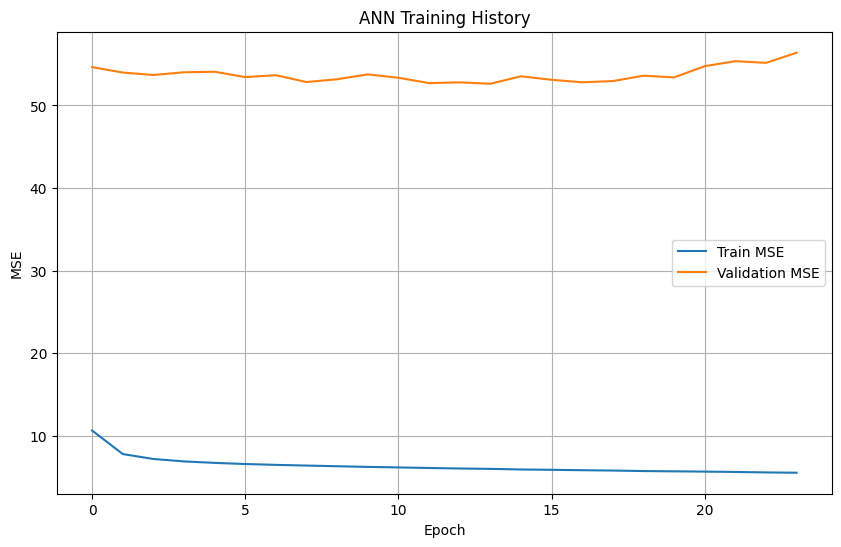

In [226]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('ANN Training History')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [227]:
ann_model.save("ann_model_4.h5")

In [228]:
loaded_model = load_model("ann_model_4.h5", custom_objects={'mse': tf.keras.metrics.MeanSquaredError()})

In [229]:
mse = loaded_model.evaluate(X_valid, y_valid)
print(mse[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.5571 - mean_squared_error: 27.5520
52.630126953125


# Transforming Test Data

In [234]:
test['year'] = test['Timestamp'].dt.year
test['month'] = test['Timestamp'].dt.month
test['day'] = test['Timestamp'].dt.day
test['hour'] = test['Timestamp'].dt.hour

In [235]:
test.drop("Timestamp", axis=1, inplace=True)

In [236]:
cols_to_fill = [col for col in numerical_cols if col not in ["year", "month", "day", "hour"]]
for col in cols_to_fill:
    test[col] = test[col].fillna(median_train_info[col])

In [237]:
for col in numerical_cols:
    test[col] = cap_outliers(test, col)

In [238]:
test[numerical_cols] = sc.transform(test[numerical_cols])

In [239]:
test.head()

,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,year,month,day,hour
0,3.729785,-0.968667,-1.006109,1.041524,-2.929918,-4.169106,-2.252976,-5.680531,-5.305866,0.509865,1.767578,-1.430717,-1.37109
1,-0.254028,-0.956808,-0.983625,1.041524,-2.767761,-3.949675,-2.169467,-5.720764,-5.344498,0.509865,1.767578,-1.430717,-1.37109
2,-0.254028,-0.931139,-0.997405,1.041524,-2.753347,-3.996965,-2.587014,-6.062966,-5.674492,0.509865,1.767578,-1.430717,-1.37109
3,-0.254028,-0.940909,-1.006109,1.041524,-2.811003,-3.971171,-2.241046,-5.486150,-5.119489,0.509865,1.767578,-1.430717,-1.37109
4,-0.254028,-0.960987,-0.956788,1.041524,-2.884874,-4.112860,-2.491575,-5.749695,-5.372514,0.509865,1.767578,-1.430717,-1.37109


# Prepare Submission

In [246]:
y_pred = ann_model.predict(test)

457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [247]:
sample_submission["Turbidity"] = y_pred
sample_submission.head()

,Record number,Turbidity
0,54916,2.248692
1,54917,2.492589
2,54918,2.935626
3,54919,2.503162
4,54920,2.743500


In [250]:
sample_submission.to_csv("submission7.csv", index=False)

In [251]:
sample_submission.describe()

,Record number,Turbidity
count,14610.000000,14610.000000
mean,62269.965435,5.998577
std,4246.259213,2.951587
min,54916.000000,1.108577
25%,58592.250000,3.948604
50%,62269.500000,5.243752
75%,65946.750000,7.341626
max,69625.000000,17.957273
